In [2]:
import importlib
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix
import seaborn as sns

from Project.utils.storage import truth_db as t_db
from Project.utils.storage import bluesky_db as b_db

importlib.reload(t_db)
importlib.reload(b_db)

truth_db = t_db.SQLiteTruthSaver(db_name='../db/truthsocial.db')
bluesky_db = b_db.SQLiteBlueSkySaver(db_name='../db/bluesky.db')

C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# THE PLAN:

# 1. Label some comments from both socials, with Gemini

# 2. Fine tune a HuggingFace model

# 3. Run the model, don't care about performance honestly


In [2]:
truth_db.cursor.execute("""
SELECT content, gemini_label
FROM Posts NATURAL JOIN CommentAnalysis
""")
truth_data = truth_db.cursor.fetchall()

bluesky_db.cursor.execute("""
SELECT content, gemini_label
FROM Posts NATURAL JOIN CommentAnalysis
""")
bluesky_data = bluesky_db.cursor.fetchall()

data = truth_data + bluesky_data

df = pd.DataFrame(data, columns=['content', 'label'])
df['label'] = [{'Neutral': 0, 'Republican': 1, 'Democratic': 2}.get(l) for l in df['label']]

In [3]:
df

,content,label
0,<p>Score!</p>,0
1,<p>The 170 can make maple syrup!</p>,0
2,<p>Exactly and they’re not just in one party !...,0
3,<p>why dont you go away</p>,0
4,<p>Democrats are destroying America. Why? Is i...,1
...,...,...
4395,California led the way on this one. Don’t forg...,0
4396,📌I see Gavin Newsom saying that a man who is r...,2
4397,That's the point. So there's nothing left but ...,2
4398,A stroller does not have to cost a thousand bu...,0


In [4]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Ensures balanced splits
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 3520, Test size: 880


In [5]:
# Model

model_name = "matous-volf/political-leaning-politics"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3  # 0, 1, 2
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "launch/POLITICS",
    use_fast=False
)


def tokenize_function(data):
    return tokenizer(
        data['content'],
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )

In [6]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 880/880 [00:00<00:00, 1299.09 examples/s]


In [7]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.5090, 2.1295, 1.7671])


In [8]:

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)

    return {
        'accuracy': accuracy,
        'f1_macro': report['macro avg']['f1-score'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
    }

class BalancedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None) -> bool:
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, 3), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    num_train_epochs=2,
    warmup_steps=100,  # Start with a smaller LR
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.05,  # Regularization
    eval_steps=100,  # How often it does evaluation
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,  # Needed if metric is f1 instead of loss
    report_to=None,
    learning_rate=8e-05,
    warmup_ratio=0.15,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.1,
    fp16=True,
)

trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))


C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_22204\3765356686.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BalancedTrainer.__init__`. Use `processing_class` instead.
  trainer = BalancedTrainer(


In [9]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
100,No log,1.094779,0.427273,0.433743,0.434950,0.520460,0.567865
200,No log,0.783444,0.673864,0.631904,0.689337,0.626560,0.680005
300,No log,0.886105,0.620455,0.591645,0.639221,0.586402,0.674433
400,No log,0.885285,0.698864,0.647959,0.713429,0.627893,0.700685
500,0.955600,0.883728,0.611364,0.597530,0.624529,0.606995,0.711862
600,0.955600,0.912209,0.738636,0.693881,0.747501,0.684211,0.732795
700,0.955600,0.817026,0.671591,0.647426,0.684749,0.631622,0.738038
800,0.955600,0.777660,0.719318,0.687594,0.730683,0.666877,0.753367


TrainOutput(global_step=880, training_loss=0.8069284439086915, metrics={'train_runtime': 198.514, 'train_samples_per_second': 35.463, 'train_steps_per_second': 4.433, 'total_flos': 926159230402560.0, 'train_loss': 0.8069284439086915, 'epoch': 2.0})

In [10]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

Evaluation Results:
eval_loss: 0.9122086763381958
eval_accuracy: 0.7386363636363636
eval_f1_macro: 0.6938809739504072
eval_f1_weighted: 0.7475005076239375
eval_precision_macro: 0.6842108196521265
eval_recall_macro: 0.7327950085365617
eval_runtime: 4.1157
eval_samples_per_second: 213.813
eval_steps_per_second: 26.727
epoch: 2.0


In [11]:
# Save model
model.save_pretrained('../data/bluesky_truth_model')
tokenizer.save_pretrained('../data/bluesky_truth_model')

('../data/bluesky_truth_model\\tokenizer_config.json',
 '../data/bluesky_truth_model\\special_tokens_map.json',
 '../data/bluesky_truth_model\\vocab.json',
 '../data/bluesky_truth_model\\merges.txt',
 '../data/bluesky_truth_model\\added_tokens.json')

Index(['eval_loss', 'eval_accuracy', 'eval_f1_macro', 'eval_f1_weighted',
       'eval_precision_macro', 'eval_recall_macro', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step',
       'loss', 'grad_norm', 'learning_rate', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')


<Axes: >

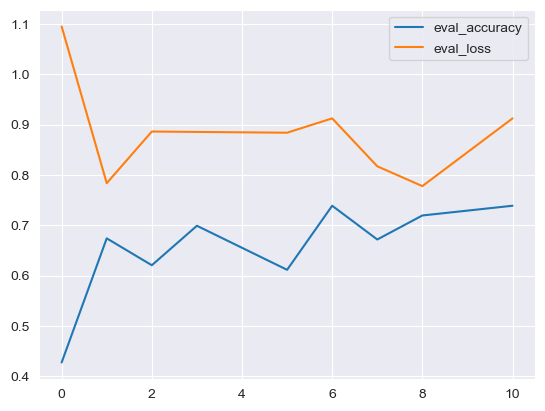

In [20]:
history = trainer.state.log_history

history_df = pd.DataFrame(history)

print(history_df.columns)

history_df['train_score'] = 1 - history_df['train_loss']
history_df['eval_score'] = 1 - history_df['eval_loss']

history_df[['eval_accuracy', 'eval_loss']].dropna().plot(subplots=False)

In [3]:
# Load model
model_path = '../data/bluesky_truth_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2212, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
      

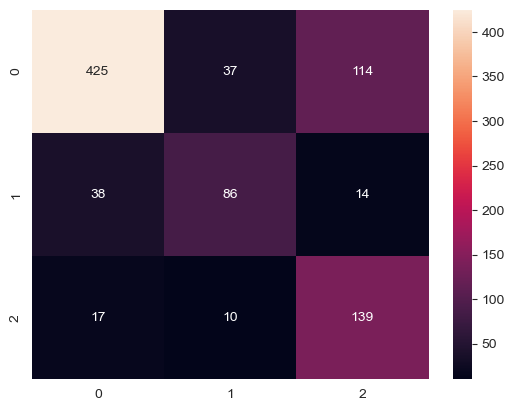

              precision    recall  f1-score   support

           0       0.89      0.74      0.80       576
           1       0.65      0.62      0.63       138
           2       0.52      0.84      0.64       166

    accuracy                           0.74       880
   macro avg       0.68      0.73      0.69       880
weighted avg       0.78      0.74      0.75       880



In [24]:
# Get predictions (this is simpler than my previous suggestion)
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print(classification_report(y_true, y_pred))

In [4]:
# Load full datasets

truth_db.cursor.execute("""
SELECT id, content
FROM Posts
""")
truth_data = truth_db.cursor.fetchall()
truth_df = pd.DataFrame(truth_data, columns=['id', 'content'])

bluesky_db.cursor.execute("""
SELECT id, content
FROM Posts
""")
bluesky_data = bluesky_db.cursor.fetchall()
bluesky_df = pd.DataFrame(bluesky_data, columns=['id', 'content'])


In [5]:
truth_df

,id,content
0,114197083930867087,"<p>Canadian Furniture Maker Closes B.C. Plant,..."
1,114197087215443716,<p>Smart move!!!</p>
2,114197089158254652,<p>Score!</p>
3,114197090765627568,<p>Need to make it law that states who receive...
4,114197093134399024,<p>Welcome future hard working American🤗</p>
...,...,...
73870,114387866091101141,<p>Tariff away sir! I want to see the IRS abol...
73871,114387907123632449,"<p>The tariffs were NOT reciprocal, and Trump,..."
73872,114387964495138238,<p>&quot;Protective Agricultural Standards&quo...
73873,114387966057950562,<p>How?</p>


In [6]:
bluesky_df

,id,content
0,bafyreid6xubyttiiz5waygebjoeph7252n3ilrh4b342o...,China’s reaction to the US Tariffs
1,bafyreihxt34udnghza4ncdfpod7uhiprf6fnxi7zpd6uj...,JUST IN: Karoline Leavitt now says there will ...
2,bafyreicqxfk3sbk6hr5nigt3hsdr3a7q2nt2a5puxdlh4...,MOTHERFUCKER NO NOT MORE TARIFFS
3,bafyreidbjqqkxs56hccgwzgb3hk3mrhkijpj4wtg4jxwv...,A dozen states sued President Trump over his t...
4,bafyreicqnjgh4pr3p5pxdbmvsqss2gsiaqav4mlim4es4...,"I'm raising tariffs, I'm cutting tariffs. I'm ..."
...,...,...
20105,bafyreifafxhr7iwiyj7tu3pspygwqjlwudhpmsi2dq2j5...,JUST IN: A federal appeals court has paused th...
20106,bafyreieo2pueka5vop65putamluewsfvovhat6hzhdxme...,A US court has blocked President Donald Trump'...
20107,bafyreiegfyxm46iiuuu5wvinrqzvnk6zylzcoyd53y536...,What? Did they think we would get tired alread...
20108,bafyreichf7lbc5se3abia6o3emjoij6gvzodwxat3j7fh...,Let's be honest. When Biden started banging on...


In [7]:
# Predict Bluesky data

all_predictions = list()

# Process in batches of size 100
batch_size = 100
for i in range(0, len(bluesky_df), batch_size):
    texts = bluesky_df['content'][i:i + batch_size].tolist()
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(dim=-1).cpu().numpy()

    all_predictions.extend(predictions)
    print(f"{i}/{len(bluesky_df)}")

bluesky_df['predicted_label'] = all_predictions

0/20110
100/20110
200/20110
300/20110
400/20110
500/20110
600/20110
700/20110
800/20110
900/20110
1000/20110
1100/20110
1200/20110
1300/20110
1400/20110
1500/20110
1600/20110
1700/20110
1800/20110
1900/20110
2000/20110
2100/20110
2200/20110
2300/20110
2400/20110
2500/20110
2600/20110
2700/20110
2800/20110
2900/20110
3000/20110
3100/20110
3200/20110
3300/20110
3400/20110
3500/20110
3600/20110
3700/20110
3800/20110
3900/20110
4000/20110
4100/20110
4200/20110
4300/20110
4400/20110
4500/20110
4600/20110
4700/20110
4800/20110
4900/20110
5000/20110
5100/20110
5200/20110
5300/20110
5400/20110
5500/20110
5600/20110
5700/20110
5800/20110
5900/20110
6000/20110
6100/20110
6200/20110
6300/20110
6400/20110
6500/20110
6600/20110
6700/20110
6800/20110
6900/20110
7000/20110
7100/20110
7200/20110
7300/20110
7400/20110
7500/20110
7600/20110
7700/20110
7800/20110
7900/20110
8000/20110
8100/20110
8200/20110
8300/20110
8400/20110
8500/20110
8600/20110
8700/20110
8800/20110
8900/20110
9000/20110
9100/20110


In [8]:
bluesky_df

,id,content,predicted_label
0,bafyreid6xubyttiiz5waygebjoeph7252n3ilrh4b342o...,China’s reaction to the US Tariffs,0
1,bafyreihxt34udnghza4ncdfpod7uhiprf6fnxi7zpd6uj...,JUST IN: Karoline Leavitt now says there will ...,2
2,bafyreicqxfk3sbk6hr5nigt3hsdr3a7q2nt2a5puxdlh4...,MOTHERFUCKER NO NOT MORE TARIFFS,0
3,bafyreidbjqqkxs56hccgwzgb3hk3mrhkijpj4wtg4jxwv...,A dozen states sued President Trump over his t...,2
4,bafyreicqnjgh4pr3p5pxdbmvsqss2gsiaqav4mlim4es4...,"I'm raising tariffs, I'm cutting tariffs. I'm ...",2
...,...,...,...
20105,bafyreifafxhr7iwiyj7tu3pspygwqjlwudhpmsi2dq2j5...,JUST IN: A federal appeals court has paused th...,2
20106,bafyreieo2pueka5vop65putamluewsfvovhat6hzhdxme...,A US court has blocked President Donald Trump'...,2
20107,bafyreiegfyxm46iiuuu5wvinrqzvnk6zylzcoyd53y536...,What? Did they think we would get tired alread...,2
20108,bafyreichf7lbc5se3abia6o3emjoij6gvzodwxat3j7fh...,Let's be honest. When Biden started banging on...,2


In [15]:
# Predict Truthsocial data

all_predictions = list()

# Process in batches of size 50
batch_size = 50
for i in range(0, len(truth_df), batch_size):
    texts = truth_df['content'][i:i + batch_size].tolist()
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(dim=-1).cpu().numpy()

    all_predictions.extend(predictions)
    print(f"{i}/{len(truth_df)}")

truth_df['predicted_label'] = all_predictions

0/73875
50/73875
100/73875
150/73875
200/73875
250/73875
300/73875
350/73875
400/73875
450/73875
500/73875
550/73875
600/73875
650/73875
700/73875
750/73875
800/73875
850/73875
900/73875
950/73875
1000/73875
1050/73875
1100/73875
1150/73875
1200/73875
1250/73875
1300/73875
1350/73875
1400/73875
1450/73875
1500/73875
1550/73875
1600/73875
1650/73875
1700/73875
1750/73875
1800/73875
1850/73875
1900/73875
1950/73875
2000/73875
2050/73875
2100/73875
2150/73875
2200/73875
2250/73875
2300/73875
2350/73875
2400/73875
2450/73875
2500/73875
2550/73875
2600/73875
2650/73875
2700/73875
2750/73875
2800/73875
2850/73875
2900/73875
2950/73875
3000/73875
3050/73875
3100/73875
3150/73875
3200/73875
3250/73875
3300/73875
3350/73875
3400/73875
3450/73875
3500/73875
3550/73875
3600/73875
3650/73875
3700/73875
3750/73875
3800/73875
3850/73875
3900/73875
3950/73875
4000/73875
4050/73875
4100/73875
4150/73875
4200/73875
4250/73875
4300/73875
4350/73875
4400/73875
4450/73875
4500/73875
4550/73875
4600/73875


In [16]:
truth_df

,id,content,predicted_label
0,114197083930867087,"<p>Canadian Furniture Maker Closes B.C. Plant,...",1
1,114197087215443716,<p>Smart move!!!</p>,0
2,114197089158254652,<p>Score!</p>,0
3,114197090765627568,<p>Need to make it law that states who receive...,0
4,114197093134399024,<p>Welcome future hard working American🤗</p>,1
...,...,...,...
73870,114387866091101141,<p>Tariff away sir! I want to see the IRS abol...,0
73871,114387907123632449,"<p>The tariffs were NOT reciprocal, and Trump,...",2
73872,114387964495138238,<p>&quot;Protective Agricultural Standards&quo...,1
73873,114387966057950562,<p>How?</p>,0


In [18]:
# Save predictions in DBs

# Edit label so that Right is +1 and Left is -1
def map_label(x):
    if x == 0: return 0
    if x == 1: return 1
    if x == 2: return -1
truth_df['predicted_label'] = [map_label(x) for x in truth_df['predicted_label']]

update_data = [(id, label) for id, label in zip(truth_df['id'], truth_df['predicted_label'])]

# Execute all at once
cursor = truth_db.cursor
cursor.executemany(
    """
    INSERT INTO CommentAnalysis (id, label)
    VALUES (?, ?)
    ON CONFLICT(id) DO UPDATE SET label = excluded.label
    """,
    update_data
)
truth_db.conn.commit()


In [19]:
def map_label(x):
    if x == 0: return 0
    if x == 1: return 1
    if x == 2: return -1
bluesky_df['predicted_label'] = [map_label(x) for x in bluesky_df['predicted_label']]

update_data = [(id, label) for id, label in zip(bluesky_df['id'], bluesky_df['predicted_label'])]

# Execute all at once
cursor = bluesky_db.cursor
cursor.executemany(
    """
    INSERT INTO CommentAnalysis (id, label)
    VALUES (?, ?)
    ON CONFLICT(id) DO UPDATE SET label = excluded.label
    """,
    update_data
)
bluesky_db.conn.commit()